In [33]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency , f_oneway, ttest_ind
from colorama import Fore, Back, Style

import plotly.express as px
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Configurar visualização dos dados
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True, precision=3)

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score

import shap

## Carregaro os dados

In [2]:
df_empresas = pd.read_csv('./companies_profile.csv')

In [3]:
df_empresas.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         1000 non-null   int64  
 1   Nome_Empresa               1000 non-null   str    
 2   Receita_Anual              1000 non-null   int64  
 3   Margem_Liquida             1000 non-null   float64
 4   Endividamento              1000 non-null   float64
 5   Setor                      1000 non-null   str    
 6   Regiao                     1000 non-null   str    
 7   Tempo_Operacao             1000 non-null   int64  
 8   Auditoria_Externa          1000 non-null   int64  
 9   Rating_Credito             1000 non-null   float64
 10  Tipo_Empresa               1000 non-null   str    
 11  Politica_Sustentabilidade  1000 non-null   str    
 12  Estrategia_Expansao        1000 non-null   str    
 13  Gestao_Risco               1000 non-null   str    
 14  Cobe

In [4]:
df_empresas.head()

,ID,Nome_Empresa,Receita_Anual,Margem_Liquida,Endividamento,Setor,Regiao,Tempo_Operacao,Auditoria_Externa,Rating_Credito,...,Estrategia_Expansao,Gestao_Risco,Cobertura_Seguros,Maturidade_Digital,Governanca_Corporativa,Cultura_Inovacao,Relacao_Comunidade,Risco_Credito,Risco_Compliance,Risco_Mercado
0,1,Hahn Group,6523388,0.483,1.033,Manufatura,Europa,26,0,0.939,...,Parcerias,Centralizada,Básica,Avançada,Fraca,Neutra,Regular,0,0,0
1,2,Lopez Group,6650634,0.121,0.493,Tecnologia,Europa,20,1,0.492,...,Orgânica,Centralizada,Básica,Inicial,Média,Neutra,Ruim,0,0,0
2,3,Sparks and Sons,4404572,0.190,0.757,Manufatura,América Latina,6,0,0.701,...,Orgânica,Decentralizada,Básica,Inicial,Alta,Neutra,Boa,0,0,0
3,4,"Fields, Ramirez and Craig",2334489,0.402,2.328,Manufatura,Europa,6,1,0.856,...,Parcerias,Centralizada,Nenhuma,Intermediária,Média,Inovadora,Excelente,1,0,0
4,5,"Campbell, Hernandez and Lyons",9624682,0.175,1.722,Saúde,América do Norte,18,1,0.418,...,Aquisições,Decentralizada,Nenhuma,Avançada,Fraca,Neutra,Regular,0,0,0


In [5]:
# Valores possíveis para variáveis categóricas

for col in df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns:
    print(f'\nValores únicos em {col}:')
    print(df_empresas[col].unique())


Valores únicos em Setor:
<StringArray>
['Manufatura', 'Tecnologia', 'Saúde', 'Financeiro']
Length: 4, dtype: str

Valores únicos em Regiao:
<StringArray>
['Europa', 'América Latina', 'América do Norte', 'Ásia']
Length: 4, dtype: str

Valores únicos em Tipo_Empresa:
<StringArray>
['MEI', 'S.A.', 'Limitada', 'Multinacional']
Length: 4, dtype: str

Valores únicos em Politica_Sustentabilidade:
<StringArray>
['Baixa', 'Alta', 'Média']
Length: 3, dtype: str

Valores únicos em Estrategia_Expansao:
<StringArray>
['Parcerias', 'Orgânica', 'Aquisições']
Length: 3, dtype: str

Valores únicos em Gestao_Risco:
<StringArray>
['Centralizada', 'Decentralizada']
Length: 2, dtype: str

Valores únicos em Cobertura_Seguros:
<StringArray>
['Básica', 'Nenhuma', 'Ampla']
Length: 3, dtype: str

Valores únicos em Maturidade_Digital:
<StringArray>
['Avançada', 'Inicial', 'Intermediária']
Length: 3, dtype: str

Valores únicos em Governanca_Corporativa:
<StringArray>
['Fraca', 'Média', 'Alta']
Length: 3, dtype: 

/tmp/ipykernel_80709/3268744689.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns:


In [6]:
# Estatisticas das variáveis numericas
df_empresas.describe()

,ID,Receita_Anual,Margem_Liquida,Endividamento,Tempo_Operacao,Auditoria_Externa,Rating_Credito,Risco_Credito,Risco_Compliance,Risco_Mercado
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,500.500,4992927.505,0.152,1.318,25.367,0.496,0.487,0.595,0.206,0.110
std,288.819,2804931.116,0.200,0.701,14.104,0.500,0.293,0.491,0.405,0.313
min,1.000,139353.000,-0.200,0.100,1.000,0.000,0.001,0.000,0.000,0.000
25%,250.750,2646177.750,-0.021,0.692,13.000,0.000,0.232,0.000,0.000,0.000
50%,500.500,5032603.000,0.160,1.364,25.000,0.000,0.476,1.000,0.000,0.000
75%,750.250,7270657.750,0.324,1.920,38.000,1.000,0.742,1.000,0.000,0.000
max,1000.000,9989550.000,0.500,2.499,49.000,1.000,0.999,1.000,1.000,1.000


## EDA

In [7]:
# Lista de variáveis numéricas
features_numericas = df_empresas.drop(columns=['ID','Risco_Credito','Risco_Compliance','Risco_Mercado']).select_dtypes(include=['int64','float64']).columns
features_numericas

Index(['Receita_Anual', 'Margem_Liquida', 'Endividamento', 'Tempo_Operacao',
       'Auditoria_Externa', 'Rating_Credito'],
      dtype='str')

In [8]:
# Visualizar a distribuição das features numéricas
for col in features_numericas:
    fig = px.histogram(df_empresas, x=col, nbins=20, title=f'Distribuição de {col}')
    fig.show()

In [9]:
# Distribuição de variáveis categóricas
features_categoricas = df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns

features_categoricas

/tmp/ipykernel_80709/2515518283.py:2: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.



Index(['Setor', 'Regiao', 'Tipo_Empresa', 'Politica_Sustentabilidade',
       'Estrategia_Expansao', 'Gestao_Risco', 'Cobertura_Seguros',
       'Maturidade_Digital', 'Governanca_Corporativa', 'Cultura_Inovacao',
       'Relacao_Comunidade'],
      dtype='str')

In [10]:
# Contagem de valores para variáveis categóricas
for col in features_categoricas:
    df_count = df_empresas[col].value_counts().reset_index()
    df_count.columns = ['categoria','contagem']

    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Distribuição/Contagem de {col}',
                 color='categoria')
    fig.show()

In [11]:
# Lista de Targets
targets = ['Risco_Credito','Risco_Compliance','Risco_Mercado']

In [12]:
# Visualizar distribuição dos targets
for col in targets:
    df_count = df_empresas[col].value_counts().reset_index()
    df_count.columns = ['categoria','contagem']

    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Distribuição/Contagem de {col}',
                 color='categoria')
    fig.show()

In [13]:
# Analisar relação entre features numericas e categoricas e os targets

for target in targets:

    for col in features_numericas:
        fig = px.box(df_empresas, x=target,color=target, y=col, title=f'{col} por {target}')
        fig.show()
    
    for col in features_categoricas:
        fig = px.histogram(df_empresas, x=col,color=target, barmode='group', title=f'{col} por {target}')
        fig.show()

In [14]:
corr_matrix = df_empresas[features_numericas.tolist() + targets].corr()

# Heatmap da matriz 

fig = px.imshow(
    corr_matrix,
    color_continuous_scale='armyrose',
    title='Matriz de Correlação',
    zmin=-1,
    zmax=1,
)

# Ajustes no heatmap

fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont=dict(size=9))

fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size =10)
)

fig.show()

In [15]:
# ANOVA - Análise de Variância (Diferença significativa média entre 3 ou mais grupos)
# Teste T-Student - (Diferença significativa média entre 2 grupos)

for col in features_numericas:

    for target in targets:

        groups = [df_empresas[df_empresas[target] == val][col] for val in df_empresas[target].unique()]

        if df_empresas[target].nunique() <= 2:

            stat, p = ttest_ind(*groups)
            teste = 'T-Test'

        elif df_empresas[target].nunique() > 2:

            stat, p = f_oneway(*groups)
            teste = 'ANOVA'
            
        print(f'{Fore.RED if p < 0.05 else Fore.WHITE}'
                  f'T-Teste entre {col} e {target}: p-valor ={p}')
        

T-Teste entre Receita_Anual e Risco_Credito: p-valor =0.9148230907469924
T-Teste entre Receita_Anual e Risco_Compliance: p-valor =0.3724539073163081
T-Teste entre Receita_Anual e Risco_Mercado: p-valor =1.432266289916743e-06
T-Teste entre Margem_Liquida e Risco_Credito: p-valor =0.714839504289611
T-Teste entre Margem_Liquida e Risco_Compliance: p-valor =7.293209908091e-67
T-Teste entre Margem_Liquida e Risco_Mercado: p-valor =0.46787005387671987
T-Teste entre Endividamento e Risco_Credito: p-valor =2.0286202656673827e-48
T-Teste entre Endividamento e Risco_Compliance: p-valor =0.02873944772709319
T-Teste entre Endividamento e Risco_Mercado: p-valor =0.6427051699118196
T-Teste entre Tempo_Operacao e Risco_Credito: p-valor =0.7368086294717285
T-Teste entre Tempo_Operacao e Risco_Compliance: p-valor =0.6875261988254968
T-Teste entre Tempo_Operacao e Risco_Mercado: p-valor =9.253489005940342e-41
T-Teste entre Auditoria_Externa e Risco_Credito: p-valor =0.12610915002115414
T-Teste entre Aud

## Preparação dos dados

In [16]:
# Separar X e y
lista_colunas_indice = ['ID', 'Nome_Empresa']


X = df_empresas.drop(columns=lista_colunas_indice + targets)
y = df_empresas[targets]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=51, shuffle=True)

In [18]:
# Isso transforma ['Setor'] em [posição_da_coluna]
cat_features_indices = [X_train.columns.get_loc(col) for col in features_categoricas]

## Treinamento do modelo Catboost com abordagem OnevsRest (OnevsAll)

In [19]:
print(f"Classes únicas no treino: {np.unique(y_train)}")
print(f"Formato do y_train: {y_train.shape}")

Classes únicas no treino: [0 1]
Formato do y_train: (500, 3)


In [20]:
# Criar o objeto Catboost
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    cat_features=cat_features_indices,
    random_strength=2,
    loss_function='Logloss'
)

In [21]:
ovr_model = OneVsRestClassifier(cat_model)

In [22]:
ovr_model.fit(X_train, y_train)

0:	learn: 0.6294599	total: 51.5ms	remaining: 51.5s
1:	learn: 0.5371508	total: 55.9ms	remaining: 27.9s
2:	learn: 0.4570634	total: 61.3ms	remaining: 20.4s
3:	learn: 0.3992278	total: 64.2ms	remaining: 16s
4:	learn: 0.3453984	total: 65.9ms	remaining: 13.1s
5:	learn: 0.2879831	total: 67.1ms	remaining: 11.1s
6:	learn: 0.2466229	total: 69ms	remaining: 9.78s
7:	learn: 0.2199186	total: 70.1ms	remaining: 8.69s
8:	learn: 0.1955501	total: 74.2ms	remaining: 8.17s
9:	learn: 0.1666704	total: 76ms	remaining: 7.52s
10:	learn: 0.1487477	total: 77.8ms	remaining: 7s
11:	learn: 0.1338095	total: 79.4ms	remaining: 6.54s
12:	learn: 0.1238168	total: 81.4ms	remaining: 6.18s
13:	learn: 0.1154578	total: 82.9ms	remaining: 5.84s
14:	learn: 0.1006511	total: 84.2ms	remaining: 5.53s
15:	learn: 0.0906420	total: 88.1ms	remaining: 5.42s
16:	learn: 0.0819758	total: 89.8ms	remaining: 5.19s
17:	learn: 0.0743135	total: 91.2ms	remaining: 4.98s
18:	learn: 0.0669086	total: 92.4ms	remaining: 4.77s
19:	learn: 0.0614129	total: 94.

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x77b55b186690>)

## Análise dos resultados e métricas

In [23]:

y_pred = ovr_model.predict(X_test)
y_pred.shape

(500, 3)

In [24]:
y_pred

array([[1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 0],
       [1, 0, 1],
       [0, 0, 0]], shape=(500, 3))

In [25]:
y_pred_proba = ovr_model.predict_proba(X_test)
y_pred_proba

array([[1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   ],
       [0.999, 0.   , 1.   ],
       [0.   , 0.   , 0.   ]], shape=(500, 3))

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.98      1.00      0.99       105
           2       1.00      1.00      1.00        55

   micro avg       0.99      1.00      1.00       453
   macro avg       0.99      1.00      1.00       453
weighted avg       0.99      1.00      1.00       453
 samples avg       0.71      0.72      0.71       453



/home/orlandojunior/miniconda3/envs/rocketseat_ia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/home/orlandojunior/miniconda3/envs/rocketseat_ia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

/home/orlandojunior/miniconda3/envs/rocketseat_ia/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.




Matriz de confusão para Risco_Credito


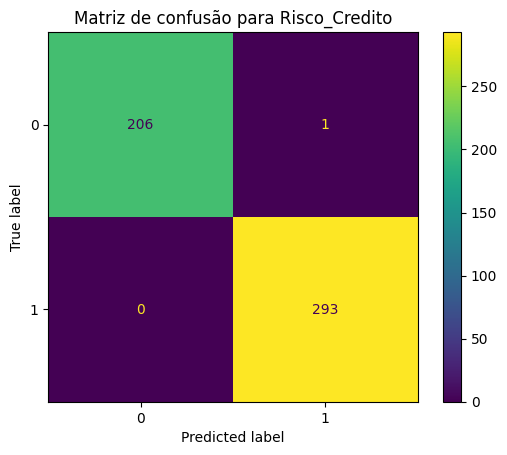


Matriz de confusão para Risco_Compliance


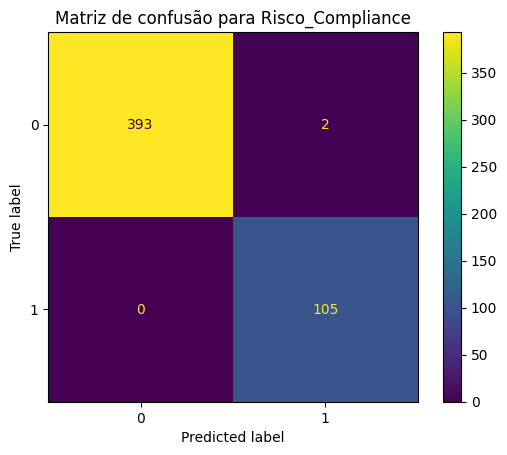


Matriz de confusão para Risco_Mercado


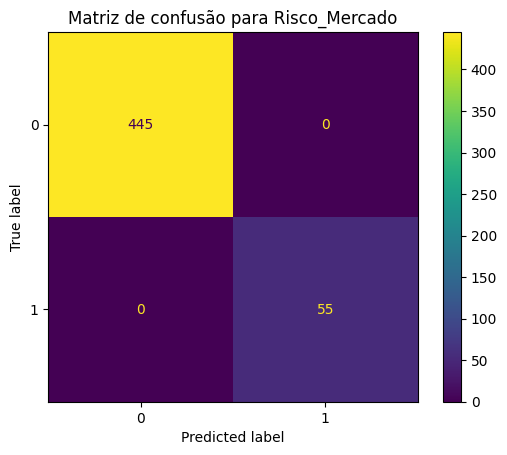

In [27]:
# Mostrar a matriz de confusão para cada classe

for i, target in enumerate(targets):
    print(f'\nMatriz de confusão para {target}')
    conf_matrix = confusion_matrix(y_test.iloc[:,i],y_pred[:,i])

    fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1])
    fig.plot()
    plt.title(f'Matriz de confusão para {target}')
    plt.show()

In [28]:
# Calcular o logloss para cada target
print('Log Loss por Target')

for i, target in enumerate(targets):
    log_loss_score = log_loss(y_test.iloc[:,i], y_pred_proba[:,i])

    print(f'{target} : {log_loss_score:.4f}')

Log Loss por Target
Risco_Credito : 0.0042
Risco_Compliance : 0.0061
Risco_Mercado : 0.0002


## Importância das variáveis - Para cada target

In [32]:


for i, target in enumerate(targets):

    importancias = ovr_model.estimators_[i].feature_importances_
    nomes_features = X.columns.tolist()

    df_importances = pd.DataFrame({'feature': nomes_features, 'importancia': importancias})

    df_importances = df_importances.sort_values(by='importancia', ascending=False).reset_index(drop=True)

    fig = px.bar(
        df_importances.head(10),
        x='importancia',
        y='feature',
        orientation='h',
        title=f'Importancia das 10 principais features - {target}',
        labels={'importancia': 'Importância', 'feature': 'Feature'},
        color='importancia',
        color_continuous_scale='ArmyRose'
    )

    fig.update_layout(
        height=600,
        yaxis={'categoryorder': 'total ascending'}
    )

    fig.show()

## Visualizar exemplo de árvore

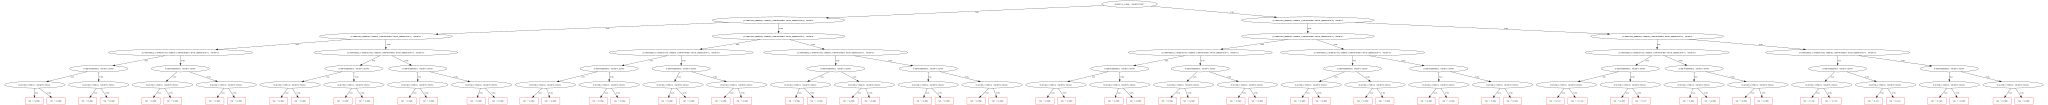

In [36]:
# Visualizar exemplo de árvore
modelo_catboost = ovr_model.estimators_[0]

# Criar o Pool com os dados de treinamento
pool = Pool(
    data=X_train,
    label= y_train.iloc[:,0],
    cat_features = features_categoricas.tolist(),
    feature_names=list(X_train.columns)
)

modelo_catboost.plot_tree(tree_idx=0,pool=pool)

## Shap Values

In [39]:
# Shap Values

# Criar e rodar os explainers para cada target

explainers = []
shap_values = []

for i, target in enumerate(targets):
    print(f'Calculando Shap Values para {target}...')

    explainer = shap.TreeExplainer(ovr_model.estimators_[i])

    # Calcular valores Shap
    shap_values_target = explainer.shap_values(X_test)
    shap_values.append(shap_values_target)
    # Atualizo as listas
    explainers.append(explainer)


Calculando Shap Values para Risco_Credito...
Calculando Shap Values para Risco_Compliance...
Calculando Shap Values para Risco_Mercado...



Gráfico SHAP para Risco_Credito


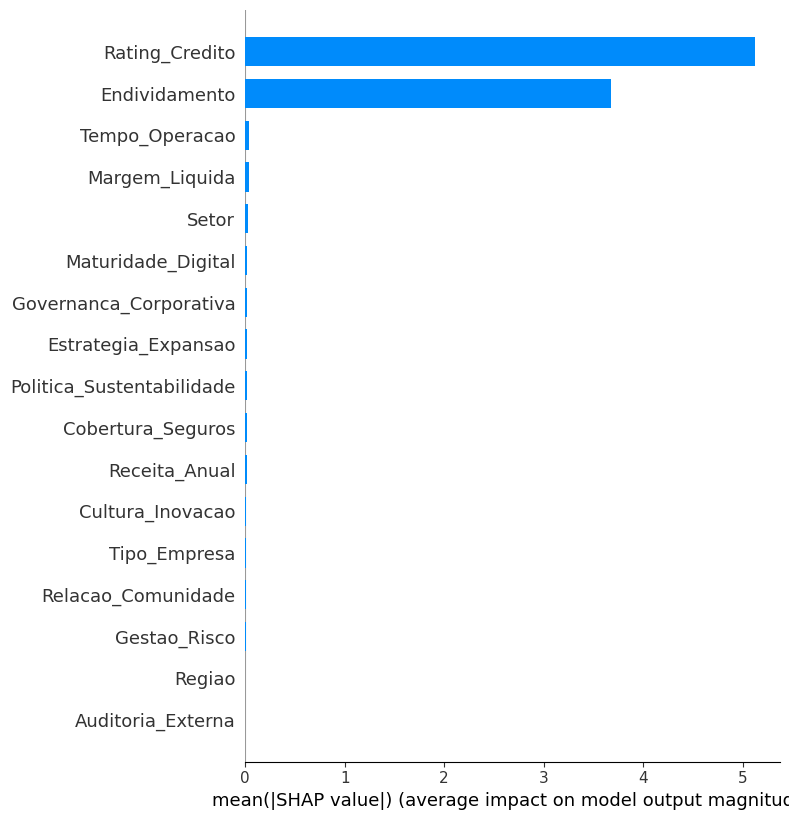

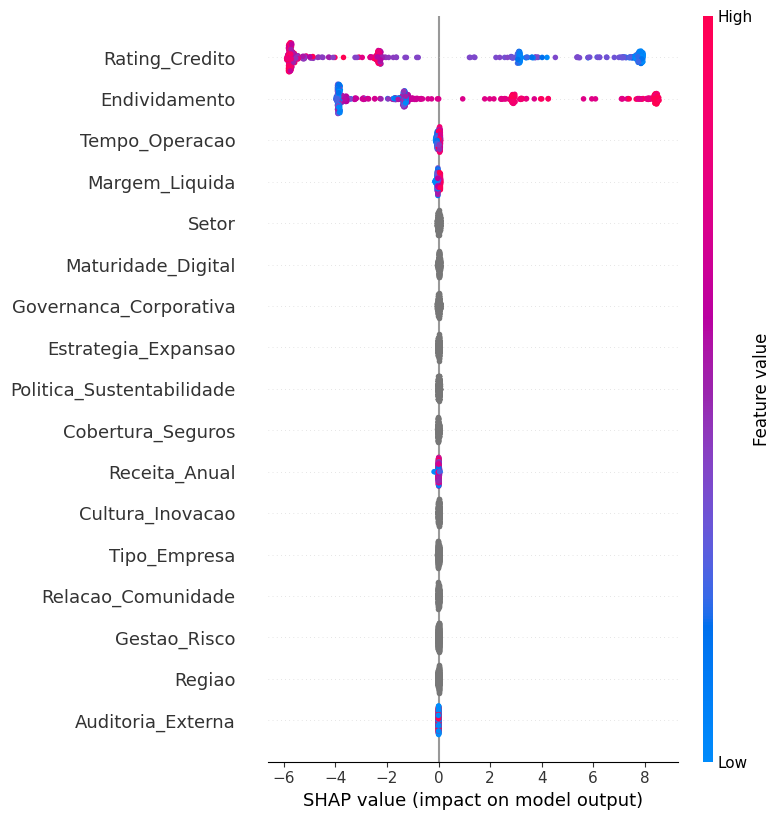


Gráfico SHAP para Risco_Compliance


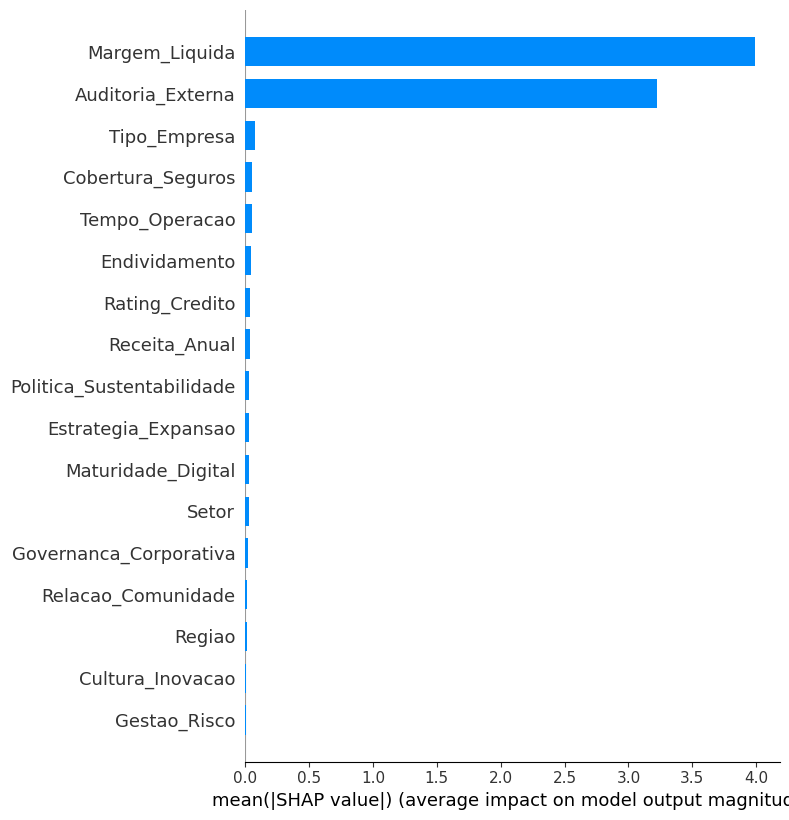

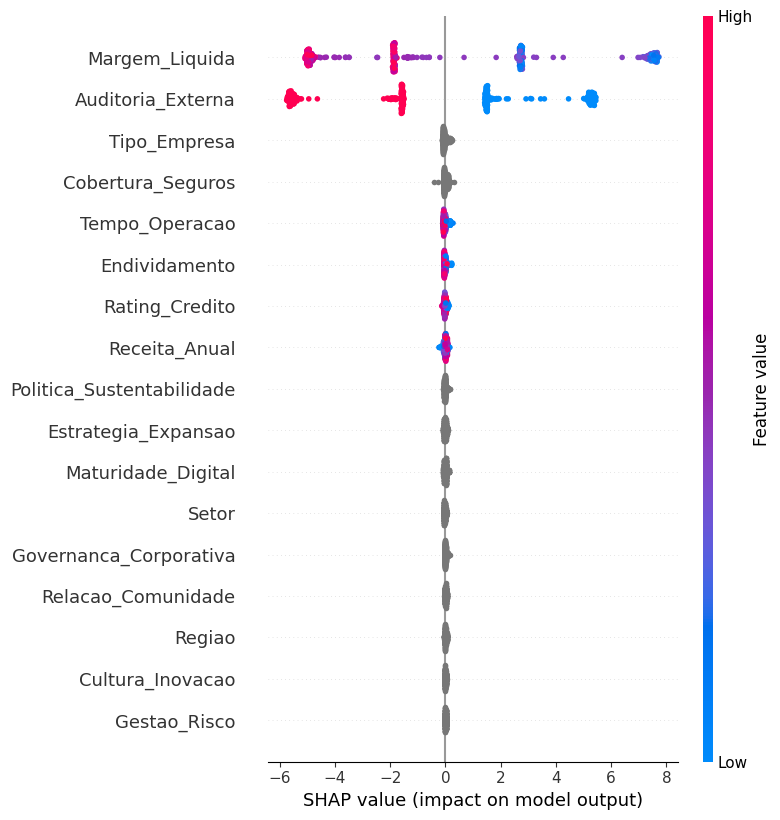


Gráfico SHAP para Risco_Mercado


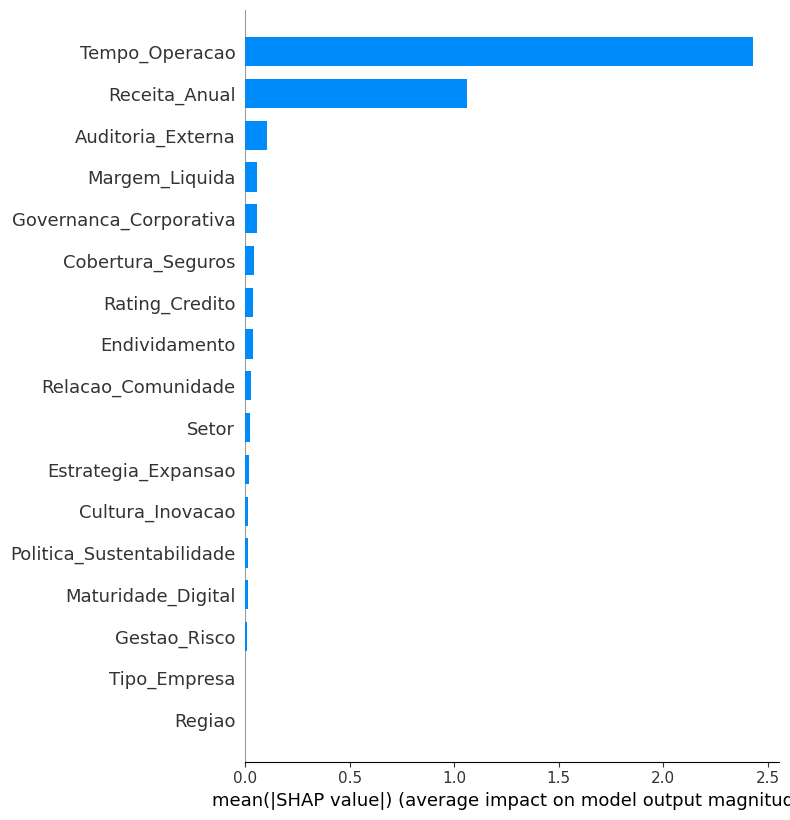

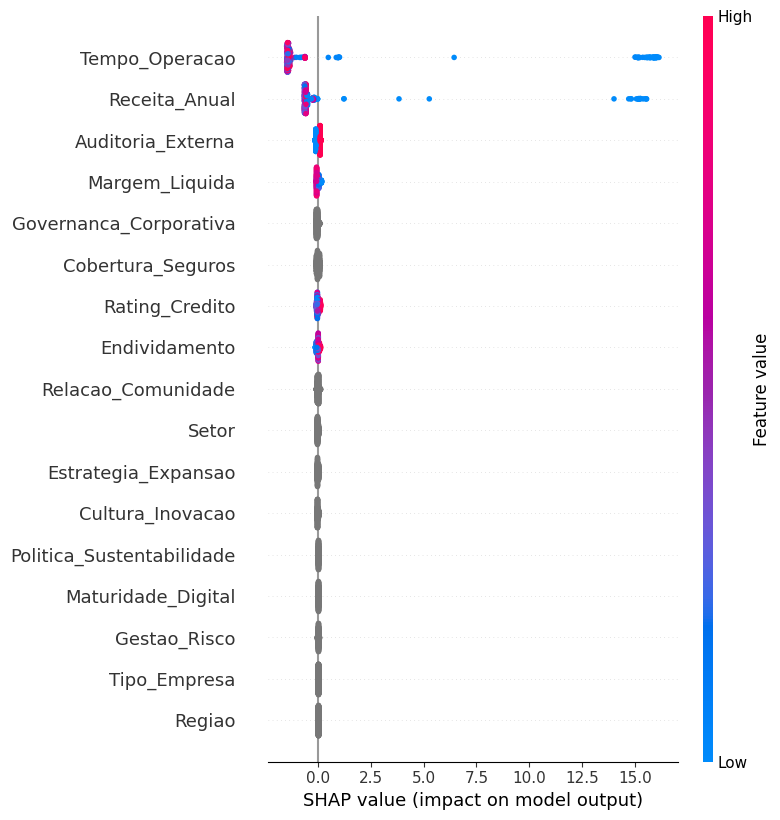

In [41]:
# Plotar gráficos para cada target

for i, target in enumerate(targets):
    print(f'\nGráfico SHAP para {target}')

    shap.summary_plot(
        shap_values[i],
        X_test,
        plot_type='bar',
        title=f'Contribuição Global das Variáveis - {target}',
        show=False
    )

     
    plt.tight_layout()
    plt.show()

    shap.summary_plot(
        shap_values[i],
        X_test,
        title=f'Distribuição dos valores SHAP - {target}',
        show=False
    )


    plt.tight_layout()
    plt.show()